## Imports

In [44]:
# Basics 
import numpy as np
import sys
import pickle
import os

# plotting 
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline 
from IPython.display import Image,display

# Scipy 
import scipy 
import scipy.stats
from scipy.optimize import minimize
from scipy.stats import truncnorm
from scipy.optimize import linprog
from scipy.io import loadmat

In [45]:
# my code 
sys.path.append('./')
sys.path.append('../shared')
sys.path.append('../policy_evaluation/')

from nCVaR_Policy_Eval import nCVaR_PE
from scenarios import Agent, setup_params
from shared import induce_P

## Load MDP from Matlab

In [46]:
# load old matlab results, which have useful info for MDP
mat = loadmat('../simulation_results/1D_optimal_policy.mat')

# Unpack 
Ny = mat['Y_set_all'].shape[1]
Ns = mat['Y_set_all'].shape[0] # could subtract one here 
Na = 3
gamma = mat['dis'][0][0]
y_set = mat['Y_set_all'][0,:]
Pol_CVaR = mat['Pol_CVaR']
P = mat['P']
r = mat['r']
print(P.shape)
print("x,x',a")

(10, 10, 3)
x,x',a


## Load Optimal Policy

In [47]:
fname = '../simulation_results/1D_optimal_policy_nCVaR.npz'
fname

'../simulation_results/1D_optimal_policy_nCVaR.npz'

In [48]:
# Load 
container = np.load(fname)
data = [container[key] for key in container]
# V = data[0]
# Xi = data[1]
# V_storage=data[2]
Q = data[3]
# Q_storage = data[4]
# Xi = data[5]
# Xi_storage = data[6]
Pi = data[7]

## Setup a python version of maze 

In [49]:
p,maze = setup_params(4) 
agent = Agent({'num_states':Ns-1,'num_actions':Na,'start_states':[4],'r_params':p['r_params']},maze)

## Setup P matrix

In [50]:
for x in range(Ns):
    for y in range(Ny):
        Pol_CVaR[x,y] = np.argmax(Pi[x,y])+1
    

In [51]:
Pol_CVaR.T

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 2, 2, 2, 2, 2, 2, 2, 2, 1],
       [1, 2, 2, 2, 2, 2, 2, 2, 1, 1],
       [1, 2, 2, 2, 2, 2, 2, 1, 3, 1],
       [1, 1, 3, 3, 2, 2, 2, 1, 3, 1],
       [1, 1, 3, 3, 3, 2, 2, 1, 3, 1]], dtype=uint8)

In [52]:
P_ssy = induce_P(P,Pol_CVaR,Ny,Ns,None,fixed_y=False)

## Run Policy Evaluation 

In [53]:
# Run Policy Evaluation 
V0 = np.repeat((mat['V_Exp']/10),Ny,1);
(V,Xi,V_storage,
 pointwise_error,V_converged,multi_starts) = nCVaR_PE(V0,Ns,Ny,P_ssy,gamma,maze,y_set,r[:,0],
                           check_pointwise_iters=6, # how many iters to start increasing multi-start
                           pointwise_window=3, # how many iters back to assess convergence for multi-start. 
                           min_multi_starts=2, # minimum number of times to run minimization for single operator
                           max_multi_starts=5, # max ""
                           max_iters=100, # max iters for evaluation algorithm 
                           verbose=False,
                           converg_thresh = 10e-5,
                           yi_pr=None,
                           converg_type = 'full_eval') 

Converged in iters=86
max error=9.348830150202048e-05
at x=8 y=5
--- 28.82198715209961 seconds ---


## Save 

In [54]:
fname = '../simulation_results/1D_optimal_policy_nCVaR_policy_eval.npz'
fname

'../simulation_results/1D_optimal_policy_nCVaR_policy_eval.npz'

In [55]:
# Save
np.savez(fname,*[V,Xi,V_storage,Pol_CVaR])

## Load

In [56]:
# Load 
container = np.load(fname)
data = [container[key] for key in container]
V = data[0]
Xi = data[1]
V_storage=data[2]
Pol_CVaR = data[3]

## Convergence

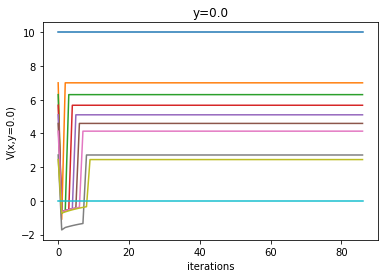

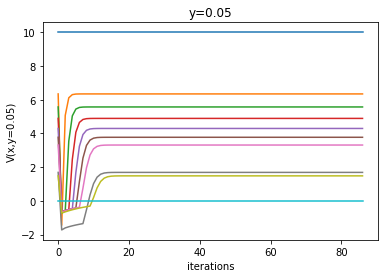

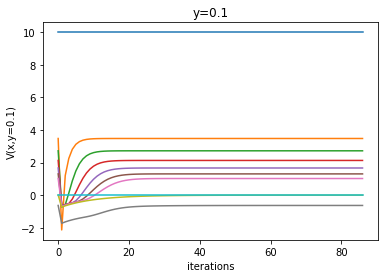

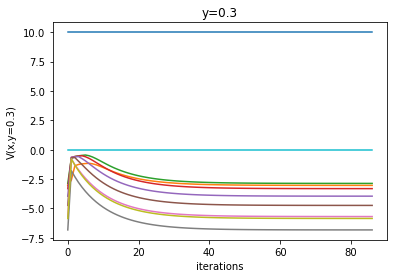

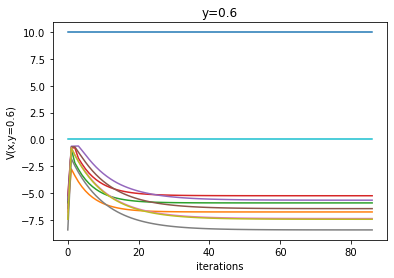

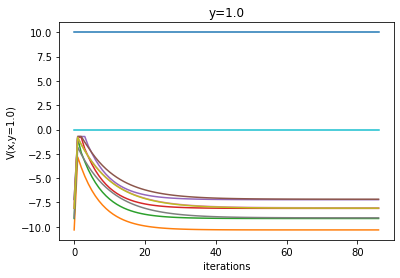

In [57]:
for y in np.arange(Ny): #[1,5,11,15,18,20]:
    plt.figure()
    plt.title('y='+str(np.round(y_set[y],2)))
    plt.plot(V_storage[:,:,y]);
    plt.xlabel('iterations')
    plt.ylabel('V(x,y='+str(np.round(y_set[y],2))+')')